In [2]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
df = pd.read_csv('monthly-beer-production-in-austr.csv')
df

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [6]:
df.Month = pd.to_datetime(df.Month)

In [7]:
df = df.set_index("Month")
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [8]:
df.index.freq = 'MS'

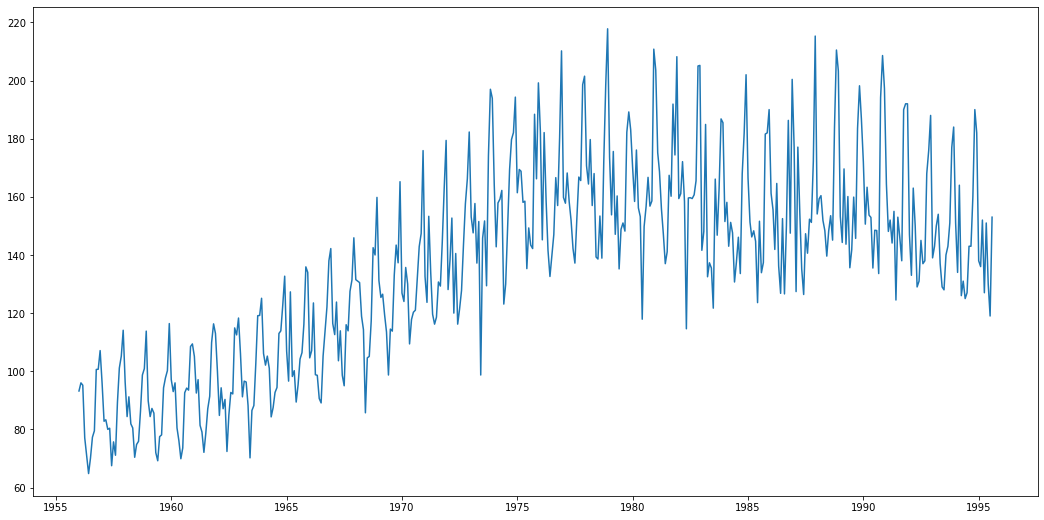

In [9]:
plt.figure(figsize=(18,9))
plt.plot(df.index, df["Monthly beer production"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Total Production')
plt.show();

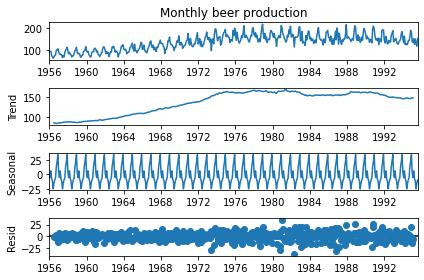

In [10]:
a = seasonal_decompose(df["Monthly beer production"], model = "add")
a.plot();

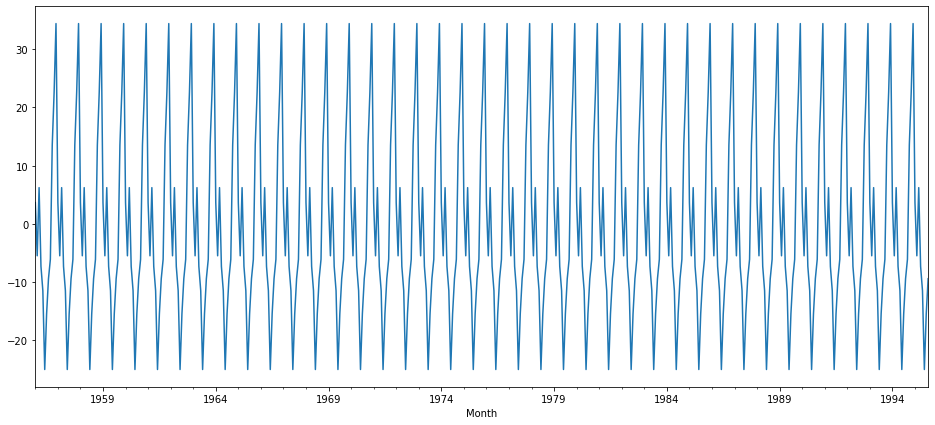

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

In [12]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [13]:
arima_model = SARIMAX(train_data['Monthly beer production'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                    Monthly beer production   No. Observations:                  464
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood               -1707.964
Date:                                    Fri, 18 Mar 2022   AIC                           3437.929
Time:                                            10:19:44   BIC                           3483.444
Sample:                                        01-01-1956   HQIC                          3455.847
                                             - 08-01-1994                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1251      0.042     -2.959      0.003      -0.208      -0.042
ar.L2         -0.1735      0.046     -3.780      0.000      -0.263      -0.084
ma.L1         -0.8462      0.027    -30.872      0.000      -0.900      -0.792
ar.S.L12       1.7542      0.119     14.799      0.000       1.522       1.986
ar.S.L24      -1.6038      0.232     -6.922      0.000      -2.058      -1.150
ar.S.L36       0.7847      0.184      4.274      0.000       0.425       1.145
ar.S.L48       0.0635      0.065      0.978      0.328      -0.064       0.191
ma.S.L12      -1.5518      0.129    -11.999      0.000      -1.805      -1.298
ma.S.L24       1.3827      0.218      6.328      0.000       0.954       1.811
ma.S.L36      -0.6580      0.128     -5.139      0.000      -0.909      -0.407
sigma2        84.6947      5.015     16.888      0.000      74.865      94.524
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                40.87
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               4.03   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

1994-09-01    134.216042
1994-10-01    157.639655
1994-11-01    181.497352
1994-12-01    183.643787
1995-01-01    144.976424
1995-02-01    136.963253
1995-03-01    151.350858
1995-04-01    133.313778
1995-05-01    137.829570
1995-06-01    120.718785
1995-07-01    128.432361
1995-08-01    138.938338
Freq: MS, Name: ARIMA Predictions, dtype: float64

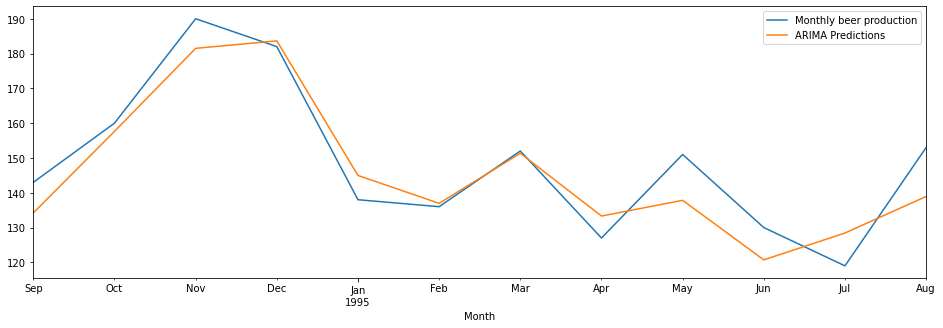

In [15]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [16]:
arima_rmse_error = rmse(test_data['Monthly beer production'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 66.15922349520687
RMSE Error: 8.133832030181523
Mean: 136.39537815126045


In [17]:
test_data['ARIMA_Predictions'] = arima_pred

# LSTM Forecast

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [19]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [20]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [22]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
452/452 [==============================] - 14s 23ms/step - loss: 0.0200
Epoch 2/20
452/452 [==============================] - 11s 25ms/step - loss: 0.0155
Epoch 3/20
452/452 [==============================] - 12s 26ms/step - loss: 0.0113
Epoch 4/20
452/452 [==============================] - 11s 25ms/step - loss: 0.0086
Epoch 5/20
452/452 [==============================] - 11s 24ms/step - loss: 0.0072
Epoch 6/20
452/452 [==============================] - 11s 24ms/step - loss: 0.0079
Epoch 7/20
452/452 [==============================] - 11s 23ms/step - loss: 0.0079 0s - loss: 
Epoch 8/20
452/452 [==============================] - 11s 24ms/step - loss: 0.0077
Epoch 9/20
452/452 [==============================] - 11s 23ms/step - loss: 0.0072
Epoch 10/20
452/452 [==============================] - 11s 23ms/step - loss: 0.0066
Epoch 11/20
452/452 [==============================] - 11s 23ms/step - loss: 0.0064 0s - loss: 0
Epoch 12/20
452/452 [==============================] - 10s 2

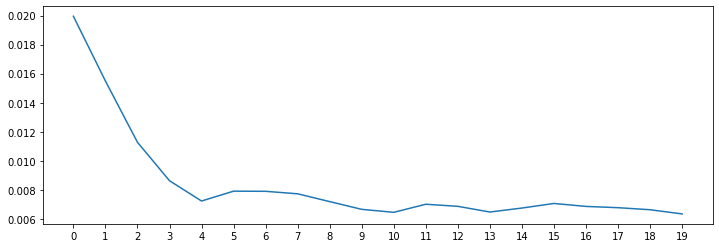

In [23]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [24]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [25]:
lstm_predictions_scaled

[array([0.50595915], dtype=float32),
 array([0.5731258], dtype=float32),
 array([0.7000716], dtype=float32),
 array([0.69501513], dtype=float32),
 array([0.53499913], dtype=float32),
 array([0.50797737], dtype=float32),
 array([0.5671331], dtype=float32),
 array([0.44313857], dtype=float32),
 array([0.44457054], dtype=float32),
 array([0.42541057], dtype=float32),
 array([0.44423708], dtype=float32),
 array([0.49281493], dtype=float32)]

In [26]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [27]:
lstm_predictions

array([[142.21175044],
       [152.48824428],
       [171.91095071],
       [171.13731526],
       [146.65486722],
       [142.52053707],
       [151.57136868],
       [132.60020115],
       [132.81929283],
       [129.88781701],
       [132.76827373],
       [140.20068403]])

In [28]:
test_data['LSTM_Predictions'] = lstm_predictions

In [29]:
test_data

,Monthly beer production,ARIMA_Predictions,LSTM_Predictions
Month,,,
1994-09-01,143.0,134.216042,142.211750
1994-10-01,160.0,157.639655,152.488244
1994-11-01,190.0,181.497352,171.910951
1994-12-01,182.0,183.643787,171.137315
1995-01-01,138.0,144.976424,146.654867
1995-02-01,136.0,136.963253,142.520537
1995-03-01,152.0,151.350858,151.571369
1995-04-01,127.0,133.313778,132.600201
1995-05-01,151.0,137.829570,132.819293


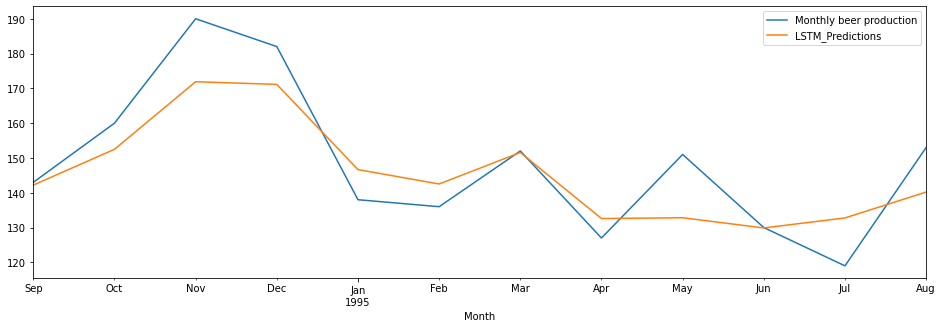

In [30]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [31]:
lstm_rmse_error = rmse(test_data['Monthly beer production'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 111.26400768679846
RMSE Error: 10.548175562001159
Mean: 136.39537815126045


# Prophet Forecast

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Freq: MS
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Monthly beer production  476 non-null    float64
dtypes: float64(1)
memory usage: 7.4 KB


In [33]:
df_pr = df.copy()
df_pr = df.reset_index()

In [34]:
df_pr.columns = ['ds','y']

In [35]:
train_data_pr = df_pr.iloc[:len(df)-12]
test_data_pr = df_pr.iloc[len(df)-12:]


In [1]:
!pip install pystan

  Using cached pystan-3.4.0-py3-none-any.whl (13 kB)
  Using cached pysimdjson-3.2.0-cp38-cp38-win_amd64.whl (151 kB)


ERROR: Could not find a version that satisfies the requirement httpstan<4.8,>=4.7 (from pystan) (from versions: 0.2.5, 0.3.0, 0.3.1, 0.4.0, 0.5.0, 0.6.0, 0.7.2, 0.7.3, 0.7.5, 0.7.6, 0.8.0, 0.9.0, 0.10.1)
ERROR: No matching distribution found for httpstan<4.8,>=4.7 (from pystan)


In [ ]:
conda install -c conda-forge fbprophet

In [ ]:
from fbprophet import Prophet

In [ ]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)

In [ ]:
prophet_pred.tail()

In [ ]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})

In [ ]:
prophet_pred = prophet_pred.set_index("Date")

In [ ]:
prophet_pred.index.freq = "MS"

In [ ]:
prophet_pred

In [ ]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["Monthly beer production"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [ ]:
prophet_rmse_error = rmse(test_data['Monthly beer production'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

In [ ]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["Monthly beer production"], linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()

In [ ]:
print(f"Mean: {test_data['Monthly beer production'].mean()}")
errors

In [ ]:
test_data
